# Tutorial: Spatially Variable Gene detection on SeqFISH+ (Mouse cortex)

This tutorial demonstrates how to use RGAST to detect SVG on a SeqFISH+ data.

## Preparation

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import warnings
import RGAST
from RGAST import svg
warnings.filterwarnings("ignore")
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)

## Read data

In [3]:
dir_input = f'../data/seqFISH/cortex_seqFISH.h5ad'
dir_output = f'./output/SVG'
if not os.path.exists(dir_output):
    os.makedirs(dir_output)
adata = sc.read_h5ad(dir_input)

## Preprocessing

In [4]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True)
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=200)

## Model training

In [ ]:
RGAST.utils.Cal_Spatial_Net(adata, rad_cutoff=80, model='Radius')
RGAST.utils.Cal_Expression_Net(adata)
#train
train_RGAST = RGAST.Train_RGAST(adata, spatial_net_arg={'rad_cutoff':80, 'model':'Radius'}, dim_reduction='PCA',device_idx=0)
train_RGAST.train_RGAST(save_path=dir_output)

## Clustering

In [11]:
from RGAST.utils import res_search_fixed_clus

sc.pp.neighbors(adata, use_rep='RGAST')
_ = res_search_fixed_clus(adata, 7)

## SVG detection pipeline

In [12]:
#Set filtering criterials
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1.5

#Search radius such that each spot in the target domain has approximately 10 neighbors on average
x_array=adata.obs["X"].tolist()
y_array=adata.obs["Y"].tolist()
adj_2d=svg.calculate_adj_matrix(x=x_array, y=y_array)
start, end= np.quantile(adj_2d[adj_2d!=0],q=0.001), np.quantile(adj_2d[adj_2d!=0],q=0.1)

In [14]:
svgene = []

for target in adata.obs['RGAST'].value_counts().index.to_list():

    r=svg.search_radius(target_cluster=target, cell_id=adata.obs.index.tolist(), x=x_array, y=y_array, pred=adata.obs['RGAST'].tolist(),
                        adj_2d=adj_2d, start=start, end=end, num_min=10, num_max=14,  max_run=100)
    #Detect neighboring domains
    nbr_domians=svg.find_neighbor_clusters(target_cluster=target,
                                    cell_id=adata.obs.index.tolist(), 
                                    x=x_array, 
                                    y=y_array, 
                                    pred=adata.obs['RGAST'].tolist(),
                                    radius=r,
                                    ratio=0.5)
    if nbr_domians is None:
        print('skip to next domain')
        continue
    if len(nbr_domians) > 3:
        nbr_domians=nbr_domians[0:3]
    de_genes_info=svg.rank_genes_groups(input_adata=adata,
                                    target_cluster=target,
                                    nbr_list=nbr_domians, 
                                    label_col='RGAST',
                                    adj_nbr=True, 
                                    log=True)

    #Filter genes
    de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
    filtered_info=de_genes_info
    filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                                (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                                (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                                (filtered_info["fold_change"]>min_fold_change)]
    filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
    filtered_info["target_dmain"]=target
    filtered_info["neighbors"]=str(nbr_domians)
    print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())
    svgene = svgene + filtered_info["genes"].tolist()

Run 1: radius [30.618406, 291.76227], num_nbr [1.9584120982986768, 100.53497164461248]
Run 2: radius [30.618406, 161.19034], num_nbr [1.9584120982986768, 34.514177693761816]
recommended radius =  95.90437 num_nbr=13.162570888468808
radius= 95.90437 average number of neighbors for each spot is 13.162570888468808
 Cluster 0 has neighbors:
Dmain  1 :  1437
Dmain  2 :  109
Dmain  3 :  53
Dmain  4 :  42
Dmain  6 :  41
Dmain  5 :  16
SVGs for domain  0 : []
Run 1: radius [30.618406, 291.76227], num_nbr [1.8401253918495297, 76.65830721003135]
Run 2: radius [30.618406, 161.19034], num_nbr [1.8401253918495297, 24.322884012539184]
Run 3: radius [95.90437, 161.19034], num_nbr [8.808777429467085, 24.322884012539184]
Run 4: radius [95.90437, 128.54736], num_nbr [8.808777429467085, 15.633228840125392]
recommended radius =  112.22587 num_nbr=12.0282131661442
radius= 112.22587 average number of neighbors for each spot is 12.0282131661442
 Cluster 1 has neighbors:
Dmain  0 :  2001
Dmain  2 :  89
Dmain 

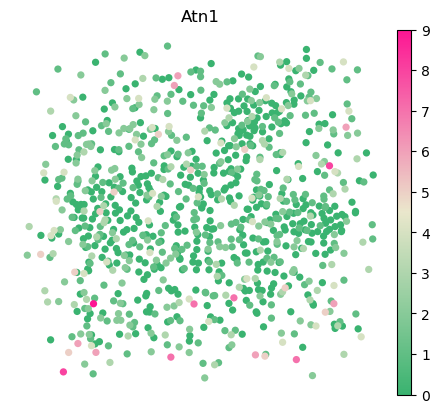

In [16]:
# visulization example
g = 'Atn1'
plt.rcParams["figure.figsize"] = (5, 5)
ax = sc.pl.scatter(adata,alpha=1,x="X",y="Y",color=g, color_map=color_self, title=g,show=False,size=100000/adata.shape[0])
ax.axis('off')
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
# plt.savefig(f'{dir_output}/domain'+str(target)+'-'+str(g)+'.pdf', bbox_inches='tight')